In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

%matplotlib inline

# Урок 2. Кейс 1. Преобразование признаков.

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза, на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

**1. Прочитайте базу "Потребление Энергии" и сделайте модель основных изменений по data_exp_1(сглаженной) с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти".**

In [152]:
data = pd.read_csv('./datasets/DUQ_hourly.csv', index_col=[0], parse_dates=[0])

data.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


In [153]:
data.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


In [154]:
# приведеине типов
data['DUQ_MW'] = data['DUQ_MW'].astype('int')

Из анализа предыдущего урока известно что не все дни содержат по 24 наблюдения. При ресэмпленге по дням пропуски и дубли значений не будут играть роли.

In [155]:
data = data.resample('D').mean()

In [156]:
data.head()

,DUQ_MW
Datetime,
2005-01-01,1352.652174
2005-01-02,1373.250000
2005-01-03,1582.958333
2005-01-04,1610.750000
2005-01-05,1711.000000


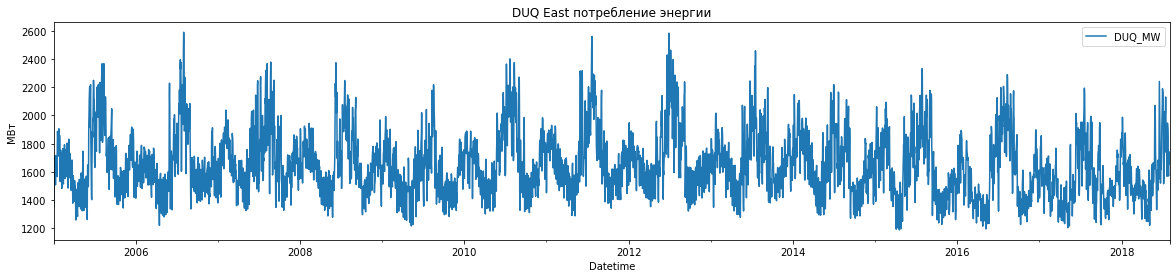

In [157]:
data.plot(style='-', figsize=(20,4))
plt.title('DUQ East потребление энергии')
plt.ylabel('МВт')
plt.show()

In [158]:
sm.tsa.stattools.adfuller(data['DUQ_MW'].values,regression='ct')

(-7.4678826060991845,
 1.2080947675830085e-09,
 29,
 4933,
 {'1%': -3.9606063811746948,
  '5%': -3.4113803777843064,
  '10%': -3.1275743050033555},
 57984.68069753283)

По критерию Дики-Фулера этот ряд стационарный. Однако он явно содержит циклическую составляющую, так что он не стационарный.

In [159]:
# экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

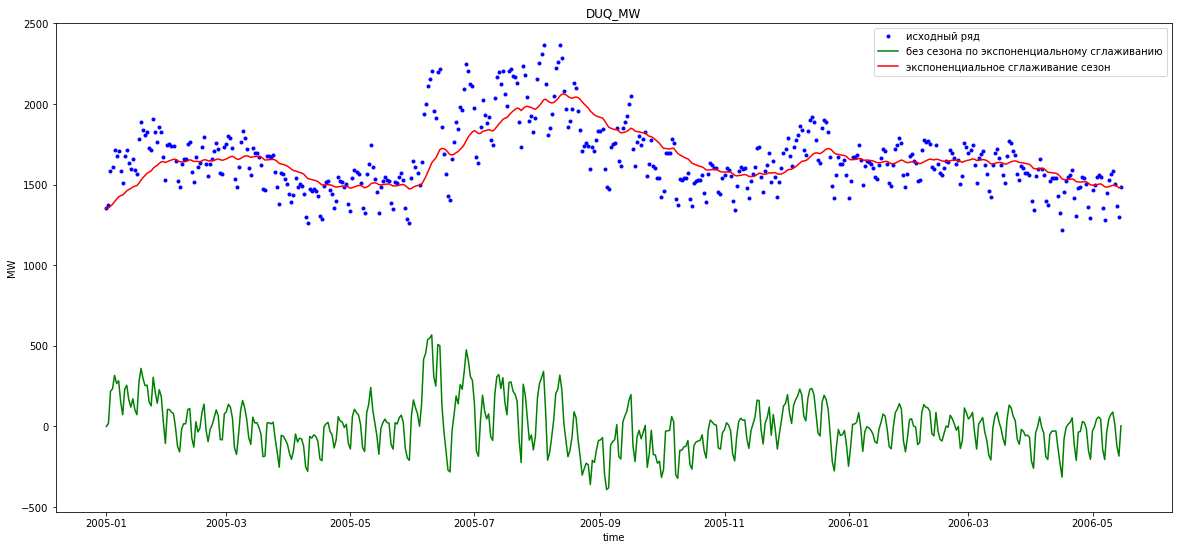

In [160]:
data_exp_1 = exponential_smoothing(data['DUQ_MW'], 0.05)
plt.figure(figsize=(20, 9))
plt.plot(data.index[:500], data['DUQ_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(data.index[:500], data['DUQ_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию")

plt.plot(data.index[:500], data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон")

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('DUQ_MW')
plt.show()

In [161]:
# добавили историю на глубину 3 измерения от текущего (р=3)
data['t'] = 0.0
data.iloc[1:,1] = data.iloc[:-1,0].values
data['t1']=0.0
data.iloc[2:,2] = data.iloc[:-2,0].values
data['t2']=0.0
data.iloc[3:,3] = data.iloc[:-3,0].values
data.fillna(0)

# добавили сглаживание (3 вида - просто для коллекции)
data['exp_0_01'] = exponential_smoothing(data['DUQ_MW'], 0.01)
data['exp_0_03'] = exponential_smoothing(data['DUQ_MW'], 0.03)
data['exp_0_08'] = exponential_smoothing(data['DUQ_MW'], 0.08)

# добавим разности - 1-й порядок
data['diff1'] = 0.0
data['diff1'].iloc[1:] = data.iloc[:-1,0].values - data.iloc[1:,0].values

data.head()

,DUQ_MW,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Datetime,,,,,,,,
2005-01-01,1352.652174,0.000000,0.000000,0.000000,1352.652174,1352.652174,1352.652174,0.000000
2005-01-02,1373.250000,1352.652174,0.000000,0.000000,1352.858152,1353.270109,1354.300000,-20.597826
2005-01-03,1582.958333,1373.250000,1352.652174,0.000000,1355.159154,1360.160755,1372.592667,-209.708333
2005-01-04,1610.750000,1582.958333,1373.250000,1352.652174,1357.715062,1367.678433,1391.645253,-27.791667
2005-01-05,1711.000000,1610.750000,1582.958333,1373.250000,1361.247912,1377.978080,1417.193633,-100.250000


In [162]:
# разбиение на тестовую и тренировочную выборку 
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [163]:
# метрика качества - средняя процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Разобьём выборку на тренировочную и тестовую

In [164]:
train, test = split_data(data, '01-01-2016')

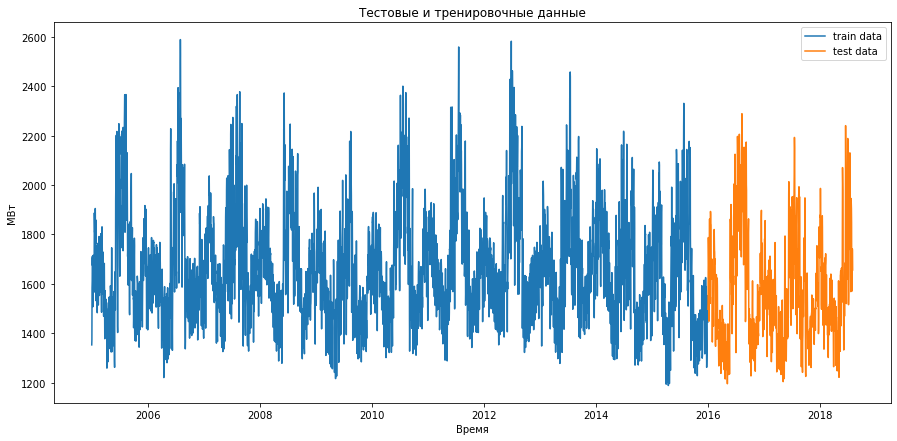

In [165]:
plt.figure( figsize=(15, 7))
plt.plot(train.index, train['DUQ_MW'], label='train data' )
plt.plot(test.index, test['DUQ_MW'], label='test data')

plt.xlabel('Время')
plt.ylabel('МВт')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

Далее строим модель.

In [166]:
model = GradientBoostingRegressor(max_depth=15, random_state=42, n_estimators=100)

In [167]:
# горизонт предсказания
h = 1

X_train = train.iloc[:-h,:]
y_train = train['DUQ_MW'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['DUQ_MW'].values[h:]

In [168]:
# обучение модели
model.fit(X_train, y_train)

# предсказание
y_test_pred = model.predict(X_test)

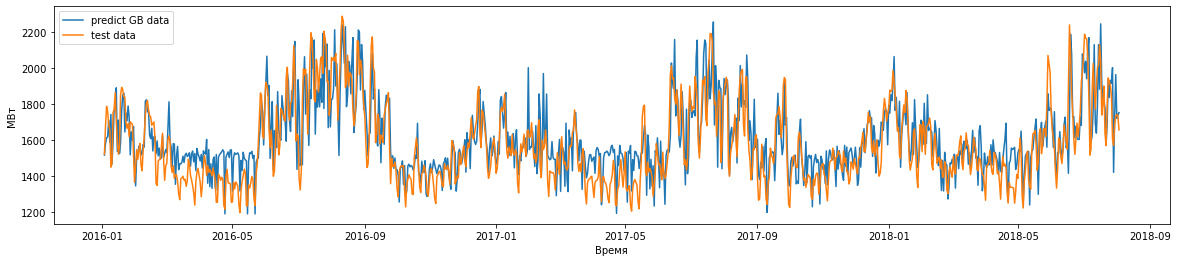

In [169]:
plt.figure(figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel('МВт')

plt.plot(test.index[h:], y_test_pred, label='predict GB data')
plt.plot(test.index[h:], y_test, label='test data')

plt.legend()
plt.show()

In [170]:
error = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)

print(f'Ошибка градиентного бустинга при h={h}: {error}%')

Ошибка градиентного бустинга при h=1: 6.883185326488521%


In [171]:
# горизонт предсказания
h = 10

X_train = train.iloc[:-h,:]
y_train = train['DUQ_MW'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['DUQ_MW'].values[h:]

In [172]:
# обучение модели
model.fit(X_train, y_train)

# предсказание
y_test_pred = model.predict(X_test)

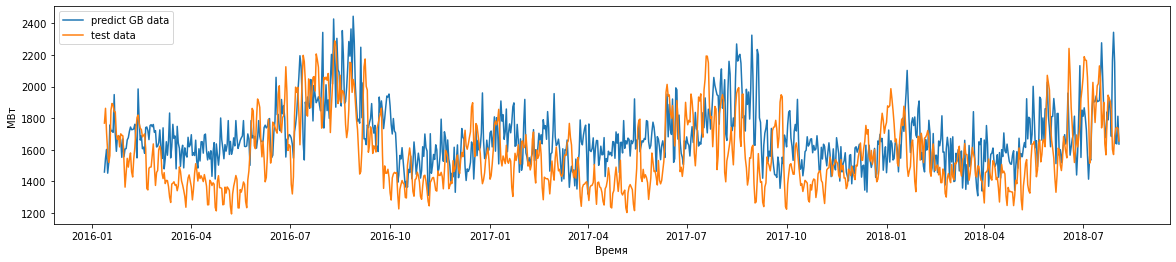

In [173]:
plt.figure(figsize=(20, 4))
plt.xlabel('Время')
plt.ylabel('МВт')

plt.plot(test.index[h:], y_test_pred, label='predict GB data')
plt.plot(test.index[h:], y_test, label='test data')

plt.legend()
plt.show()

In [174]:
error = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)

print(f'Ошибка градиентного бустинга при h={h}: {error}%')

Ошибка градиентного бустинга при h=10: 12.553455552330952%


**2. Оцените ошибку модели из п.1.**

При $h = 1$ ошибка составила $6.88\%$.

При $h = 10$ ошибка составила $12.55\%$.

**3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.**

Чем больше горизонт предсказания, тем больше ошибка.

**4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):**

    а) Изменение температуры за окном :).

Этот ряд не стационарный, так как есть циклическая составляющая. У ряда есть тренд из-за глобального потепления. Ряд с сезонностью в одни сутки и циклом в один год.

    б) Количество денег, которые тратят покупатели в интернет магазине.

Этот ряд не стационарный, так как есть циклическая составляющая. У ряда есть тренд из-за инфляции. Ряд с сезонностью в один месяц и циклом в один год. Явные признаки цикличности - в декабре траты увеличиваются, в январе уменьшаются.

    в) Вес растущего котенка.

С детализацией по дням у этого ряда будет тренд, но не будет циклической и сезонной составляющей. Из-за тренда ряд нельзя назвать стационарным.

    г) Прирост объема деревьев в лесу от времени

Так же как и с котёнком, у ряда будет тренд. Скорее всего будет сезонная составляющая, так как летом деревья растут быстрее.